In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('C:/Users/zhangy30/Desktop/Data_MA415_local/high_diamond_ranked_10min.csv')
df.head(3)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5


In [3]:
df = df.drop(df.columns[0], axis = 1)    # drop the 'gameId' column

df = df[df['blueWardsPlaced'] <= 50]  # drop the edge cases, wards placed > 50
df = df[df['redWardsPlaced'] <= 50]

df = df.drop(['blueEliteMonsters', 'blueGoldPerMin', 'redFirstBlood', 'redKills',
              'redDeaths', 'redEliteMonsters', 'redGoldDiff', 'redGoldPerMin'], axis = 1)
df.shape

(8780, 31)

In [4]:
X = df.drop('blueWins', axis = 1)
y = df.blueWins

X = (X - X.mean())/X.std()

## Logistic Only

In [5]:
lgr = LogisticRegression()

scores = cross_validate(lgr, X, y, return_train_score = True)
R2_train = scores['train_score'].mean()
R2_valid = scores['test_score'].mean()

print('train R2', R2_train.round(3))
print('validation R2', R2_valid.round(3))

train R2 0.736
validation R2 0.732


# Logistic Regressor and Feature Engineering

In [6]:

degree = []
train_R2 = []
valid_R2 = []

for k in np.arange(3) + 1:
    lgr = LogisticRegression(fit_intercept=False)
    poly = PolynomialFeatures(k, interaction_only=False, include_bias=True)
    Xe = poly.fit_transform(X)
    degree.append(k)
    cros = cross_validate(lgr, Xe, y, return_train_score=True)
    train_R2.append(cros['train_score'].mean())
    valid_R2.append(cros['test_score'].mean())
#     print(Xe.shape)

results = pd.DataFrame()
results['degree'] = degree
results['train R2'] = train_R2
results['valid R2'] = valid_R2

print(results)

C:\Users\zhangy30\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\zhangy30\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

   degree  train R2  valid R2
0       1  0.736361  0.732005
1       2  0.747295  0.716401
2       3  0.849801  0.658428


In [7]:
print("Looks like a degree of 2 is better, 3 is a little overfitting")

Looks like a degree of 2 is better, 3 is a little overfitting


## PCA

In [8]:
# %load "~/Desktop/Data_MA415_local/biplot.py
def biplot(X,n_comp,j1,j2,scale=1,alpha=0.25,s=50):
    
    import numpy as np
    import pandas as pd
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt

    #X = (X-X.mean())/X.std()
    pca = PCA(n_components=n_comp)
    pca.fit(X)
    cols = ['PC-'+str(i+1) for i in range(n_comp)]
    Z = pca.transform(X)
    Z = pd.DataFrame(Z,columns=cols)
    Z.plot.scatter(x=j1-1,y=j2-1,
                   alpha=alpha,
                   s=s,
                   figsize=(10,10))
    sd = np.sqrt(pca.explained_variance_)
    Zj1 = sd[j1-1]*np.array([1,0])
    Zj2 = sd[j2-1]*np.array([0,1])
    plt.arrow(0,0,Zj1[0],Zj1[1],head_width=0.1,color='k')
    plt.arrow(0,0,Zj2[0],Zj2[1],head_width=0.1,color='k')

    L = pca.components_
    L = pd.DataFrame(L,index=cols,columns=X.columns)
    for k in range(X.shape[1]):
        x = scale*L.iloc[j1-1,k]
        y = scale*L.iloc[j2-1,k]
        plt.arrow(0,0,x,y,head_width=0.1,color='r')
        plt.text(1.2*x,1.2*y,X.columns[k],color='black')
        plt.xlim([-3,3])
        plt.ylim([-3,3])
        
    PVE = pca.explained_variance_ratio_
    PVE = pd.Series(PVE,index=cols)
    return PVE


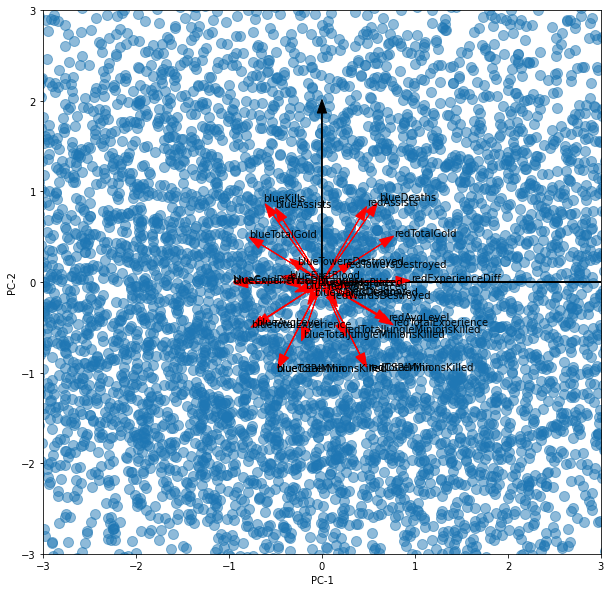

In [9]:
PVE = biplot(X, 30, 1, 2, scale=2.5, alpha = 0.5, s = 100)

In [10]:
PVE

PC-1     3.032034e-01
PC-2     1.159356e-01
PC-3     6.588633e-02
PC-4     5.538483e-02
PC-5     4.806865e-02
PC-6     4.402474e-02
PC-7     4.180756e-02
PC-8     4.021580e-02
PC-9     3.759687e-02
PC-10    3.663715e-02
PC-11    3.231368e-02
PC-12    2.752921e-02
PC-13    2.545132e-02
PC-14    2.318731e-02
PC-15    2.241703e-02
PC-16    2.131344e-02
PC-17    1.508480e-02
PC-18    1.216995e-02
PC-19    1.117051e-02
PC-20    6.411591e-03
PC-21    5.347278e-03
PC-22    3.633307e-03
PC-23    2.602755e-03
PC-24    1.547962e-03
PC-25    1.058941e-03
PC-26    5.979633e-32
PC-27    3.499380e-33
PC-28    3.179492e-33
PC-29    3.083437e-33
PC-30    2.217739e-33
dtype: float64

<AxesSubplot:>

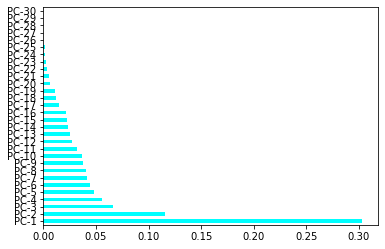

In [11]:
PVE.plot.barh(color='cyan')

## Random Forest with PCA

In [50]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)


grid = {'n_estimators':np.arange(1,201, 20),'max_depth':np.arange(1,30)}

rf = RandomForestClassifier()
rfCV = GridSearchCV(rf, param_grid=grid, return_train_score=True, n_jobs=-1)

rfCV.fit(X_pca, y)

print(f'best number of trees {rfCV.best_params_}')
print(f'validation score is {rfCV.best_score_}')

best number of trees {'max_depth': 2, 'n_estimators': 121}
validation score is 0.7307517084282459


## Random Forest

In [12]:
rf = RandomForestClassifier(n_estimators=500, oob_score=True)
rf.fit(X, y)
print(f'out of bag score {rf.oob_score_.round(3)}')

out of bag R2 0.728


## Random Forest with Feature Engineering

In [13]:
poly = PolynomialFeatures(2, interaction_only=False, include_bias=True)
Xe = poly.fit_transform(X)

rf = RandomForestClassifier(n_estimators=500, oob_score=True)
rf.fit(Xe, y)
print(f'out of bag score {rf.oob_score_.round(3)}')

out of bag R2 0.725


## Support Vector Machine

In [44]:
grid = {'C':np.arange(1, 10, 1), 'kernel':['rbf'],'gamma':np.arange(0.1, 10, 1)}


clf = SVC()
clfCV = GridSearchCV(clf, param_grid=grid, return_train_score=True, n_jobs=-1)


In [45]:
clfCV.fit(X, y)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'gamma': array([0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1]),
                         'kernel': ['rbf']},
             return_train_score=True)

In [46]:
print(f'best parameters {clfCV.best_params_}')
print(f'validation score is {clfCV.best_score_}')

best parameters {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
validation score is 0.721867881548975


## Support Vector Machine Linear

In [51]:
grid = {'C':np.arange(0.01, 2, 0.1), 'kernel':['linear']}

clf = SVC()
clfCV = GridSearchCV(clf, param_grid=grid, return_train_score=True, n_jobs=-1)
clfCV.fit(X, y)

print(f'best parameters {clfCV.best_params_}')
print(f'validation score is {clfCV.best_score_}')

best parameters {'C': 0.01, 'kernel': 'linear'}
validation score is 0.7322323462414578


## SVP with Feature Engineering

In [ ]:
grid = {'C':np.arange(0.01, 2, 0.5), 'kernel':['rbf'],'gamma':np.arange(0.01, 20, 3)}


clf = SVC()
clfCV = GridSearchCV(clf, param_grid=grid, return_train_score=True, n_jobs=-1)
clfCV.fit(Xe, y)

print(f'best parameters {clfCV.best_params_}')
print(f'validation score is {clfCV.best_score_}')